# Import Library

In [4]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from google_play_scraper import Sort, reviews, reviews_all
from nltk.tokenize import  word_tokenize
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from seaborn import histplot
from requests import get
from io import StringIO

import pandas as pd
import csv, re, string, json, nltk

In [5]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/yelf/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yelf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Scrapping Data

In [6]:
pubgReviews = reviews_all(
    app_id='com.tencent.ig',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT
)

In [7]:
# Membuat DataFrame dari hasil pubgReviews
raw_df = pd.DataFrame(pubgReviews)

# Menghitung jumlah baris dan kolom dalam DataFrame
jumlah_ulasan, jumlah_kolom = raw_df.shape
print("Baris : {} & Kolom : {}".format(jumlah_ulasan, jumlah_kolom))

Baris : 49500 & Kolom : 11


# Text Preprocessing

In [8]:
clean_df = raw_df.dropna()
clean_df = clean_df.drop_duplicates()

jumlah_ulasan, jumlah_kolom = clean_df.shape
print("Baris : {} & Kolom : {}".format(jumlah_ulasan, jumlah_kolom))

Baris : 13261 & Kolom : 11


### define function

In [9]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka
    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text
 
def casefoldingText(text):
    return text.lower()

def fix_slangwords(text):
    with open('combined_slang_words.txt', 'r') as file:
        slangwords = json.loads(file.readline())
    words = text.split()
    fixed_words = []
 
    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)
 
    return ' '.join(fixed_words)

def tokenizingText(text):
    return word_tokenize(text)
 
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
 
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text
 
def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    return ' '.join(word for word in list_words)

### Apply to dataset

In [10]:
print("Proses Cleaning     : START")
raw_df['text_clean'] = raw_df['content'].apply(cleaningText)
print("Proses Cleaning     : DONE\n")

print("Proses Case Folding : START")
raw_df['text_casefolding'] = raw_df['text_clean'].apply(casefoldingText)
print("Proses Case Folding : DONE\n")

print("Proses Slangword    : START")
raw_df['text_slangwords'] = raw_df['text_casefolding'].apply(fix_slangwords)
print("Proses Slangword    : DONE\n")

print("Proses Tokenizing   : START")
raw_df['text_tokenizingText'] = raw_df['text_slangwords'].apply(tokenizingText)
print("Proses Tokenizing   : DONE\n")

print("Proses Stopword     : START")
raw_df['text_stopword'] = raw_df['text_tokenizingText'].apply(filteringText)
print("Proses Stopword     : DONE\n")

print("Proses Stemming     : START")
raw_df['text_stemming'] = raw_df['text_stopword'].apply(filteringText)
print("Proses Stemming     : DONE\n")

print("Proses Final        : START")
raw_df['text_akhir'] = raw_df['text_stemming'].apply(toSentence)
print("Proses Final        : DONE\n")


Proses Cleaning     : START
Proses Cleaning     : DONE

Proses Case Folding : START
Proses Case Folding : DONE

Proses Slangword    : START
Proses Slangword    : DONE

Proses Tokenizing   : START
Proses Tokenizing   : DONE

Proses Stopword     : START
Proses Stopword     : DONE

Proses Stemming     : START
Proses Stemming     : DONE

Proses Final        : START
Proses Final        : DONE



# Labeling

In [32]:
lexicon_positive, lexicon_negative = {}, {}

def sentiment_analysis_lexicon_indonesia(text):
    score = 0
 
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
 
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
 
    sentiment=''
 
    if (score > 0) :sentiment = 'positive'
    elif (score < 0) :sentiment = 'negative'
    else: sentiment = 'neutral'
 
    return score, sentiment

response = get(url='https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')

def create_dict(url, dictType):
    response = get(url=url)
    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text), delimiter=',')
        if dictType == 'positive':
            print("Fetching {} lexicon data".format(dictType))
            for row in reader:
                lexicon_positive[row[0]] = int(row[1])
        else:
            print("Fetching {} lexicon data".format(dictType))
            for row in reader:
                lexicon_negative[row[0]] = int(row[1])
    else:
        print("Failed to fetch lexicon data")

create_dict('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv', "positive")
create_dict('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv', "negative")
print("")

results = raw_df['text_stemming'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
raw_df['polarity_score'] = results[0]
raw_df['sentiment'] = results[1]
print(raw_df['sentiment'].value_counts())

Fetching positive lexicon data
Fetching negative lexicon data

sentiment
negative    25918
positive    20164
neutral      3418
Name: count, dtype: int64


# Undersampling

In [39]:
neg_num, pos_num, neu_num = raw_df.sentiment.value_counts()
# print("Negative : {}\nPositive : {}\nNeutral  : {}".format(neg_num, pos_num, neu_num ))

neg_class_pre, pos_class_pre, neu_class = raw_df[raw_df.sentiment == 'negative'], raw_df[raw_df.sentiment == 'positive'], raw_df[raw_df.sentiment == 'neutral']
neg_class = neg_class_pre.sample(neu_num)
pos_class = pos_class_pre.sample(neu_num)

# Generate final dataframe
df = pd.concat([neg_class, pos_class, neu_class], axis=0)

# Visualization

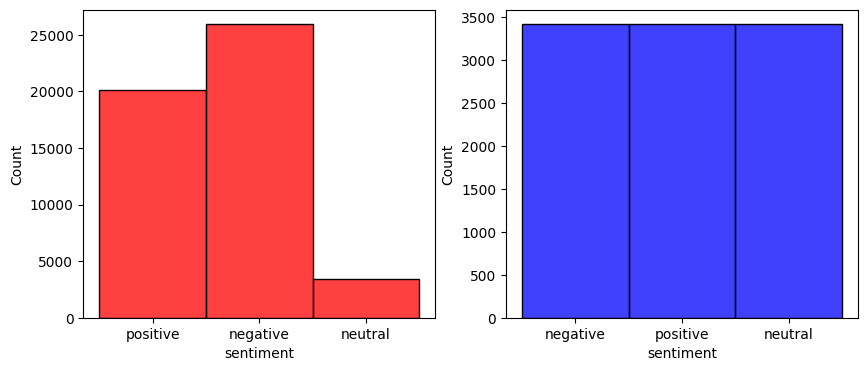

In [43]:
fig,axes = plt.subplots(1,2,figsize=(10,4))
histplot(data=raw_df, x='sentiment', ax=axes[0], color='red')
histplot(data=df, x='sentiment', ax=axes[1], color='blue')
plt.show()

# Save Dataset

In [57]:
# Remove unused field from dataset
dataset = df.drop(
    [
        'reviewId', 
        'userName', 
        'userImage', 
        'thumbsUpCount', 
        'reviewCreatedVersion', 
        'at', 
        'replyContent', 
        'repliedAt', 
        'appVersion', 
        'score',
        'content',
        'text_clean',
        'text_casefolding',
        'text_slangwords',
        'text_tokenizingText',
        'text_stopword',
        'polarity_score',
        'text_stemming'
    ], axis=1)

# new_header = {'content' : "Text Original", 'text_akhir' : 'Text Clean','polarity_score' : 'polarity', 'sentiment' : 'Sentiment'}
new_header = {'text_akhir' : 'Text Clean', 'sentiment' : 'Sentiment'}
dataset.rename(columns=new_header, inplace=True)

# Saving daataset
dataset.to_csv("dataset_pubg.csv", index=False)

dataset.head()

,Text Clean,Sentiment
22671,kecewa capek capek bunuh musuh headshot bertur...,negative
16260,plisss pembaruan download ulang seharian downl...,negative
25435,taii update jam ehh ngeleg musuh didepan mati ...,negative
19071,bagus sayang gk hp ram rendah tolong update ku...,negative
776,login pasword email sinyalnya bagus sudahnya p...,negative


In [60]:
min = 0
for text in raw_df['text_stemming']:
    # print(text)
    count = len(text)
    # print(count)
    if count > min :
        min = count
        max = count
    # print("Nilai Max Now : {} | Nilai Baca : {}".format(max, count))
print("Kalimat terpanjang terdiri dari {} kata". format(max))

Kalimat terpanjang terdiri dari 113 kata
